<a href="https://colab.research.google.com/github/novis10813/Portfolio-Optimizer/blob/main/Autoencoder_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

跑完這邊直接拿
1. encoded_train
2. encoded_test

內部皆儲存3維Tensor



In [186]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader


window_length = 60
test_samples = int(814*0.2)
asset_list = ['SPY', 'IVV', 'VTI', 'VOO', 'QQQ', 'BTC', 'ETH', 'USDC-USD']

In [265]:
"""
Read data and make percentage change
"""
prices_data = pd.read_csv('/content/close_price.csv')

df = prices_data.copy().drop(['Unnamed: 0'], axis = 1)
df = df.set_index(['date'])

df_pct_change = df.pct_change(1).astype(float)
df_pct_change = df_pct_change.tail(len(df_pct_change) - 1)

In [266]:
"""
Transfer data into tensor
"""
df_test = df_pct_change.reset_index(drop = True)[-test_samples:]
df_train = df_pct_change.reset_index(drop = True)[:-test_samples]


L = len(df_train)
l = len(df_test)


df_train = df_train.T
df_train = df_train.reset_index(drop = True)
df_train = np.array(df_train.T).reshape(L,1,8)
print(df_train)





[[[-7.32224686e-03 -2.86865137e-03 -1.45929995e-03 ... -1.28535587e-03
    4.63974283e-03 -1.76267532e-03]]

 [[-8.32064871e-03 -3.71427019e-03 -3.16635845e-02 ... -3.22948283e-02
    2.74112928e-03 -3.18480297e-02]]

 [[-1.54364903e-01 -5.73007617e-02 -2.20260693e-02 ... -2.10484289e-02
    1.58572615e-04 -2.13231468e-02]]

 ...

 [[ 1.34364761e-01 -2.62310340e-02 -9.90238397e-03 ... -9.79302189e-03
   -5.99576554e-05 -1.17486735e-02]]

 [[ 5.68263440e-02  1.52165293e-02 -8.92464389e-03 ... -8.77081527e-03
    1.49962730e-04 -8.04871112e-03]]

 [[-8.21909191e-02 -1.25303577e-01 -2.12452587e-02 ... -2.13464309e-02
   -6.99641681e-05 -2.25238274e-02]]]


In [267]:
df_test = df_test.T
df_test = df_test.reset_index(drop = True)
df_test = np.array(df_test.T).reshape(l,1,8)
print(df_test)

[[[-2.97846231e-02  2.43575779e-03  1.20124964e-02 ...  1.18852975e-02
   -2.73022385e-04  1.10204216e-02]]

 [[ 9.70952806e-02  3.04342925e-03  1.53552118e-02 ...  1.53515982e-02
    1.38009044e-04  1.70818976e-02]]

 [[-1.94817211e-01 -1.26403193e-01 -2.54438611e-03 ... -2.40240808e-03
    1.38049607e-04 -2.13409372e-03]]

 ...

 [[-4.28757522e-02 -2.26471078e-02  1.27920187e-03 ...  1.20866901e-03
   -1.37684183e-03  5.77382259e-04]]

 [[ 2.19370229e-02  1.41081048e-02 -2.76452628e-03 ... -2.82454193e-03
    8.83397969e-04 -1.60754795e-03]]

 [[-8.57796764e-03 -1.95155506e-02 -2.52017279e-03 ... -2.74112284e-03
   -3.06857765e-04 -3.17906973e-03]]]


In [268]:
dataloader_train = DataLoader(df_train, batch_size=window_length, num_workers=0)
dataloader_test = DataLoader(df_test, batch_size = window_length, num_workers = 0)

for data in dataloader_train:
  
  print(data.size())

torch.Size([60, 1, 8])
torch.Size([60, 1, 8])
torch.Size([60, 1, 8])
torch.Size([60, 1, 8])
torch.Size([60, 1, 8])
torch.Size([60, 1, 8])
torch.Size([60, 1, 8])
torch.Size([60, 1, 8])
torch.Size([60, 1, 8])
torch.Size([60, 1, 8])
torch.Size([52, 1, 8])


In [269]:
for data in dataloader_test:
  print(data.size())

torch.Size([60, 1, 8])
torch.Size([60, 1, 8])
torch.Size([42, 1, 8])


In [270]:
"""
Convolutional Autoencoder
"""
from torch.nn.modules.activation import Sigmoid
from torchsummary import summary


class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=8, out_channels=16,kernel_size=3,padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool1d(1, padding=0),  # b, 16, 5, 5
            nn.Conv1d(in_channels = 16, out_channels = 8, kernel_size = 3, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool1d(1, padding = 0)  # b, 8, 2, 2
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=8, out_channels = 8, kernel_size = 3, padding=1),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.Upsample(1),
            nn.ConvTranspose1d(in_channels =8, out_channels = 16, kernel_size = 1),  # b, 1, 28, 28
            nn.ReLU(True),
            nn.Upsample(1),
            nn.ConvTranspose1d(in_channels =16, out_channels = 8, kernel_size = 3,padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
model = autoencoder()
summary(model, (8,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 16, 1]             400
              ReLU-2                [-1, 16, 1]               0
         MaxPool1d-3                [-1, 16, 1]               0
            Conv1d-4                 [-1, 8, 1]             392
              ReLU-5                 [-1, 8, 1]               0
         MaxPool1d-6                 [-1, 8, 1]               0
   ConvTranspose1d-7                 [-1, 8, 1]             200
              ReLU-8                 [-1, 8, 1]               0
          Upsample-9                 [-1, 8, 1]               0
  ConvTranspose1d-10                [-1, 16, 1]             144
             ReLU-11                [-1, 16, 1]               0
         Upsample-12                [-1, 16, 1]               0
  ConvTranspose1d-13                 [-1, 8, 1]             392
          Sigmoid-14                 [-

In [271]:
"""
parameters
"""
num_epochs = 50
learning_rate = 1e-3
criterion = nn.BCELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-5)

In [272]:
"""
Model training
"""

train_loss = 0
for epoch in range(num_epochs):
  
    for data in dataloader_train:       
       # ===================forward=====================
      
        data = torch.transpose(data,1,2)
        data = data.to(torch.float32)
        optimizer.zero_grad()
        outputs = model(data)
        # perform a single optimization step (parameter update)
        loss = criterion(outputs, data)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()
       
    # ===================log========================
    train_loss = train_loss/len(dataloader_train)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
          epoch, 
          train_loss
          ))
    

Epoch: 0 	Training Loss: 0.672909
Epoch: 1 	Training Loss: 0.721510
Epoch: 2 	Training Loss: 0.713453
Epoch: 3 	Training Loss: 0.700019
Epoch: 4 	Training Loss: 0.685553
Epoch: 5 	Training Loss: 0.670112
Epoch: 6 	Training Loss: 0.653376
Epoch: 7 	Training Loss: 0.635144
Epoch: 8 	Training Loss: 0.615311
Epoch: 9 	Training Loss: 0.593794
Epoch: 10 	Training Loss: 0.570489
Epoch: 11 	Training Loss: 0.545094
Epoch: 12 	Training Loss: 0.517181
Epoch: 13 	Training Loss: 0.486127
Epoch: 14 	Training Loss: 0.451196
Epoch: 15 	Training Loss: 0.411725
Epoch: 16 	Training Loss: 0.367416
Epoch: 17 	Training Loss: 0.318525
Epoch: 18 	Training Loss: 0.266073
Epoch: 19 	Training Loss: 0.212898
Epoch: 20 	Training Loss: 0.163165
Epoch: 21 	Training Loss: 0.120766
Epoch: 22 	Training Loss: 0.087811
Epoch: 23 	Training Loss: 0.064136
Epoch: 24 	Training Loss: 0.048031
Epoch: 25 	Training Loss: 0.037353
Epoch: 26 	Training Loss: 0.030269
Epoch: 27 	Training Loss: 0.025472
Epoch: 28 	Training Loss: 0.02

In [273]:
"""
Get encoded Training Data
"""


def getEncodedData(data):
  data = torch.tensor(data)
  data = torch.transpose(data,1,2)
  data = data.to(torch.float32)
  encoded_data = model.encoder(data)
  encoded_data = torch.transpose(data,1,2)
  encoded_data = encoded_data.detach().numpy() 
  
  return encoded_data




encoded_train = getEncodedData(df_train)
print(encoded_train)

[[[-7.3222467e-03 -2.8686514e-03 -1.4592999e-03 ... -1.2853559e-03
    4.6397429e-03 -1.7626754e-03]]

 [[-8.3206492e-03 -3.7142702e-03 -3.1663585e-02 ... -3.2294828e-02
    2.7411294e-03 -3.1848028e-02]]

 [[-1.5436490e-01 -5.7300761e-02 -2.2026069e-02 ... -2.1048428e-02
    1.5857261e-04 -2.1323146e-02]]

 ...

 [[ 1.3436475e-01 -2.6231034e-02 -9.9023841e-03 ... -9.7930217e-03
   -5.9957656e-05 -1.1748673e-02]]

 [[ 5.6826346e-02  1.5216529e-02 -8.9246435e-03 ... -8.7708151e-03
    1.4996273e-04 -8.0487113e-03]]

 [[-8.2190916e-02 -1.2530358e-01 -2.1245258e-02 ... -2.1346431e-02
   -6.9964168e-05 -2.2523828e-02]]]


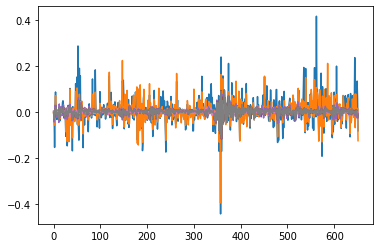

In [274]:
plt.plot(encoded_train[:,0])

In [275]:
print(encoded_train.shape)

(652, 1, 8)


In [276]:
"""
Get the Encoded Testing data
"""

encoded_test = getEncodedData(df_test)
print(encoded_test)

[[[-2.97846235e-02  2.43575778e-03  1.20124966e-02 ...  1.18852975e-02
   -2.73022393e-04  1.10204220e-02]]

 [[ 9.70952809e-02  3.04342923e-03  1.53552117e-02 ...  1.53515982e-02
    1.38009040e-04  1.70818977e-02]]

 [[-1.94817215e-01 -1.26403198e-01 -2.54438608e-03 ... -2.40240805e-03
    1.38049611e-04 -2.13409378e-03]]

 ...

 [[-4.28757519e-02 -2.26471070e-02  1.27920182e-03 ...  1.20866904e-03
   -1.37684180e-03  5.77382278e-04]]

 [[ 2.19370220e-02  1.41081046e-02 -2.76452629e-03 ... -2.82454188e-03
    8.83397995e-04 -1.60754798e-03]]

 [[-8.57796799e-03 -1.95155498e-02 -2.52017286e-03 ... -2.74112285e-03
   -3.06857779e-04 -3.17906984e-03]]]


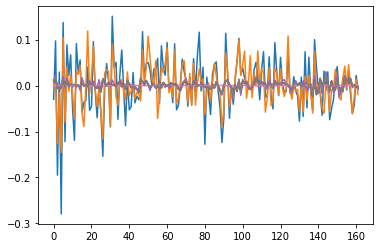

In [277]:
plt.plot(encoded_test[:,0])

In [278]:
print(encoded_test.shape)

(162, 1, 8)
